In [ ]:
#======================================================================
# Import necessary libraries
#======================================================================
# Install the necessary packages
!pip install pygam patsy statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import  LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from patsy import dmatrix
from statsmodels.api import OLS
from pygam import LinearGAM, s, f
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set seed for reproducibility
student_id = '4741644011'
first_three = int(student_id[:3])
last_three = int(student_id[-3:])
Randomizer = first_three + last_three
np.random.seed(Randomizer)
print(f"Randomizer seed: {Randomizer}")

#======================================================================
# Load and Explore the Data
#======================================================================
# Load the dataset from the sample_data directory in Google Colab
abalone = pd.read_csv('/content/sample_data/abalone.csv')

# Display the first few rows of the dataset
print(abalone.head())

# Check for missing values and data types
print(abalone.info())
# Encode the 'Sex' column using one-hot encoding and ensure 'Sex_F' is included
abalone_encoded = pd.get_dummies(abalone, columns=['Sex'], drop_first=False)

# Ensure all columns are numeric and handle NaNs
abalone_encoded = abalone_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

#======================================================================
# Calculate Descriptive Statistics for Original Data
#======================================================================
def calculate_descriptive_stats(df, columns):
    stats_df = pd.DataFrame()
    stats_df['Mean'] = df[columns].mean()
    stats_df['Median'] = df[columns].median()
    stats_df['Mode'] = df[columns].mode().iloc[0]
    stats_df['St. Deviation'] = df[columns].std()
    stats_df['Range'] = df[columns].max() - df[columns].min()
    stats_df['IQR'] = df[columns].quantile(0.75) - df[columns].quantile(0.25)
    stats_df['Skewness'] = df[columns].skew()
    stats_df['Kurtosis'] = df[columns].kurtosis()
    return stats_df

numeric_columns = abalone.select_dtypes(include=[np.number]).columns
original_descriptive_stats = calculate_descriptive_stats(abalone, numeric_columns)
print("\nDetailed Descriptive Statistics for Original Data:")
print(original_descriptive_stats)
#======================================================================
# Check for missing values
#======================================================================
print("Check for missing values:")
print(abalone_encoded.isnull().sum())
#======================================================================
# Calculate Variance Inflation Factor (VIF)
#======================================================================
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Drop non-numeric columns
abalone_encoded = abalone_encoded.select_dtypes(include=[np.number])
# Calculate VIF for the encoded dataset
vif_data = calculate_vif(abalone_encoded)
print("Variance Inflation Factor (VIF):")
print(vif_data)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
Randomizer seed: 485
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3

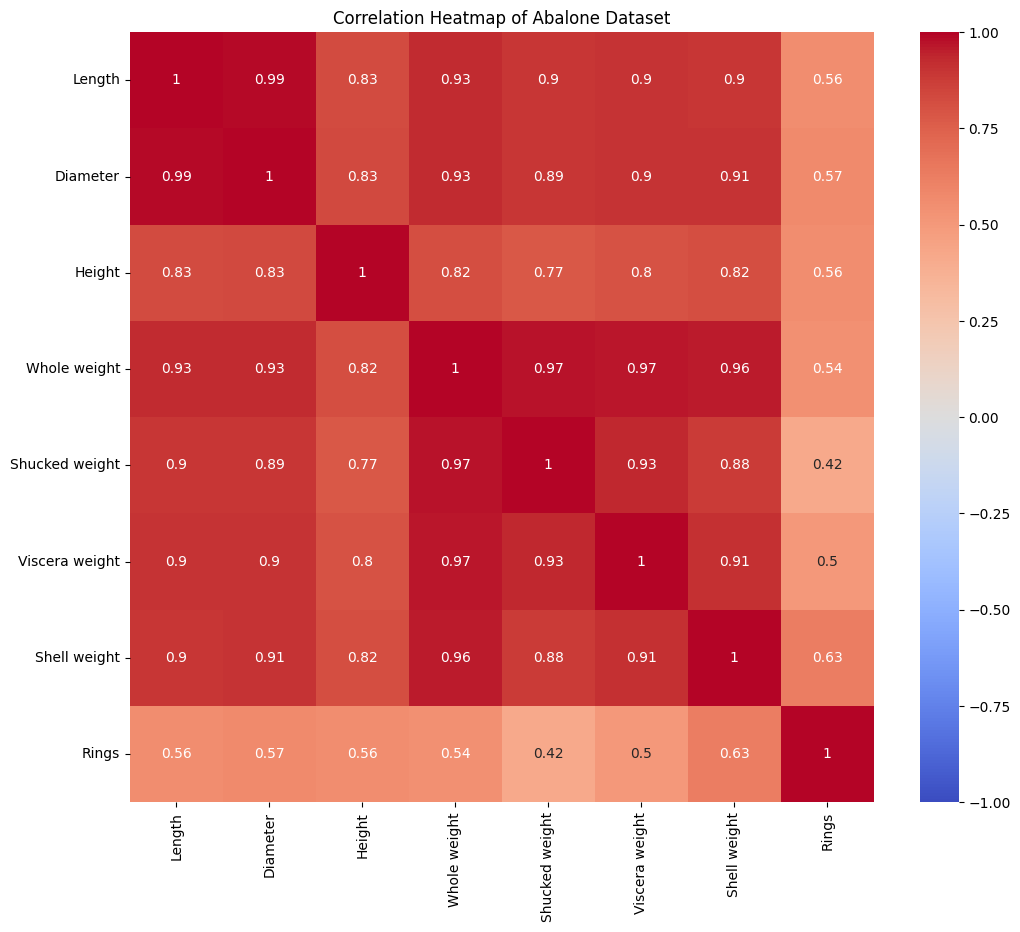

Correlation Matrix:
                   Length  Diameter    Height  Whole weight  Shucked weight  \
Length          1.000000  0.986812  0.827554      0.925261        0.897914   
Diameter        0.986812  1.000000  0.833684      0.925452        0.893162   
Height          0.827554  0.833684  1.000000      0.819221        0.774972   
Whole weight    0.925261  0.925452  0.819221      1.000000        0.969405   
Shucked weight  0.897914  0.893162  0.774972      0.969405        1.000000   
Viscera weight  0.903018  0.899724  0.798319      0.966375        0.931961   
Shell weight    0.897706  0.905330  0.817338      0.955355        0.882617   
Rings           0.556720  0.574660  0.557467      0.540390        0.420884   

                Viscera weight  Shell weight     Rings  
Length                0.903018      0.897706  0.556720  
Diameter              0.899724      0.905330  0.574660  
Height                0.798319      0.817338  0.557467  
Whole weight          0.966375      0.955355  0.

In [ ]:

#======================================================================
# Data Visualization
#======================================================================
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(abalone_encoded.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Abalone Dataset')
plt.show()

# Interpretation of the Correlation Matrix:
correlation_matrix = abalone_encoded.corr()
print("Correlation Matrix:\n", correlation_matrix)
# Select key variables based on correlations
selected_columns = ['Whole weight', 'Shell weight', 'Length', 'Diameter', 'Height', 'Rings']
print("Selected Columns based on correlation with Rings:\n", selected_columns)


In [ ]:
text="""
# The correlation matrix shows the pairwise correlations between all variables
# in the dataset.
# Variables like 'Whole weight', 'Shell weight', 'Length', 'Diameter', and
#'Height' have strong positive correlations with the target variable 'Rings'.
# These variables are likely to be important predictors for modeling the 'Rings' variable.
"""

Selected Columns based on correlation with Rings:
 ['Whole weight', 'Shell weight', 'Length', 'Diameter', 'Height', 'Rings']


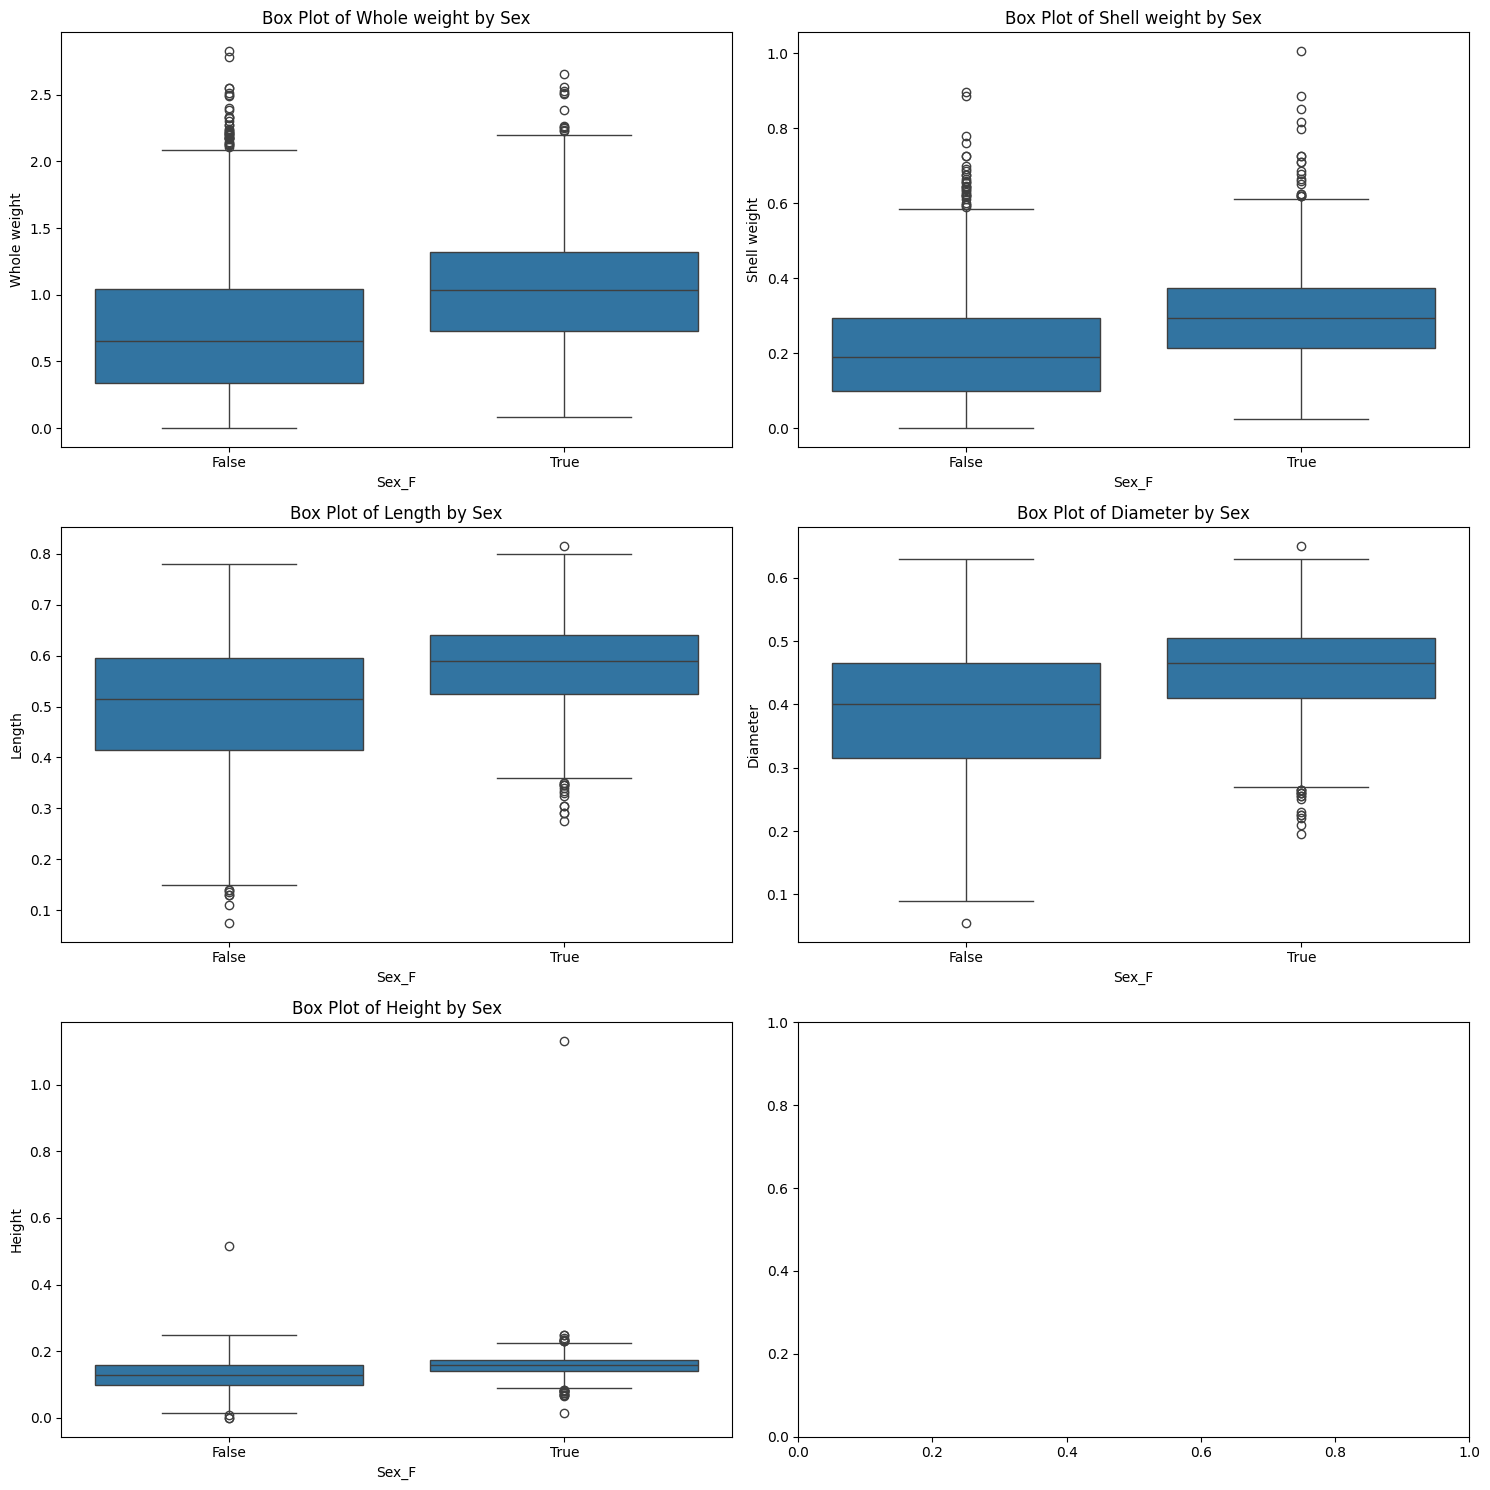

In [ ]:
#======================================================================
# Box Plots
#======================================================================
# Encode the 'Sex' column using one-hot encoding and ensure 'Sex_F' is included
abalone_encoded = pd.get_dummies(abalone, columns=['Sex'], drop_first=False)

# Ensure all columns are numeric and handle NaNs
abalone_encoded = abalone_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

# Select key variables based on correlations
selected_columns = ['Whole weight', 'Shell weight', 'Length', 'Diameter', 'Height', 'Rings']
print("Selected Columns based on correlation with Rings:\n", selected_columns)

# Box Plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    if column != 'Rings':
        sns.boxplot(x=abalone_encoded['Sex_F'], y=abalone_encoded[column], ax=axes[i])
        axes[i].set_title(f'Box Plot of {column} by Sex')
plt.tight_layout()
plt.show()

In [ ]:
text = """
### Box Plot Interpretation
The box plots reveal noticeable outliers in the Whole Weight, Shell Weight,
Length, Diameter, and Height variables when grouped by Sex. For Whole Weight
and Shell Weight, both categories (Female and Non-Female) show outliers, with
the Female category displaying a more spread distribution in the upper range.
Length and Diameter distributions are quite similar across sexes, with some
outliers present. Height shows the most significant outliers, especially in
the upper range for Non-Females, and the distribution is heavily skewed.
These plots suggest that addressing the outliers in these variables,
particularly Height, will be important for accurate analysis.
"""
print(text)


### Box Plot Interpretation
The box plots reveal noticeable outliers in the Whole Weight, Shell Weight,
Length, Diameter, and Height variables when grouped by Sex. For Whole Weight
and Shell Weight, both categories (Female and Non-Female) show outliers, with
the Female category displaying a more spread distribution in the upper range.
Length and Diameter distributions are quite similar across sexes, with some
outliers present. Height shows the most significant outliers, especially in
the upper range for Non-Females, and the distribution is heavily skewed.
These plots suggest that addressing the outliers in these variables,
particularly Height, will be important for accurate analysis.



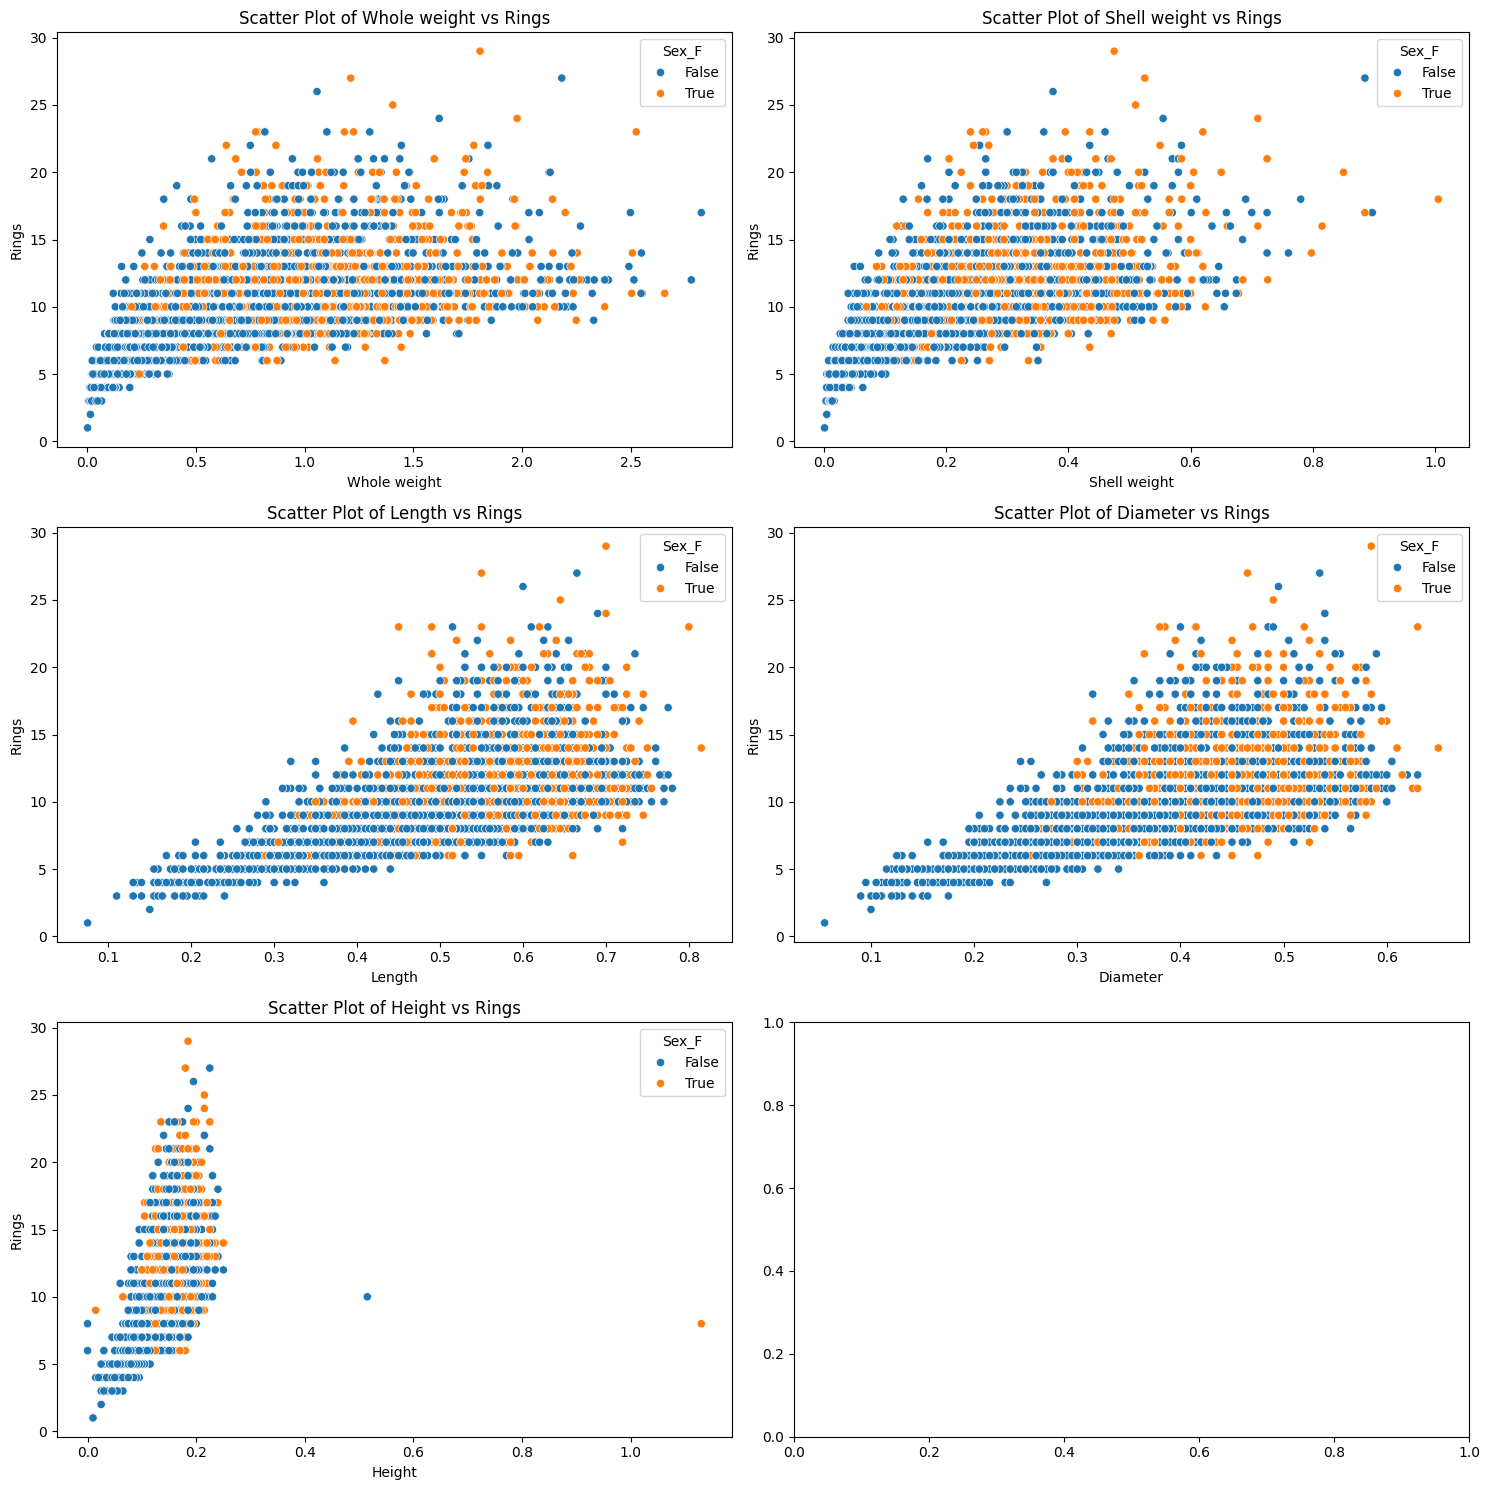

In [ ]:
#======================================================================
# Scatter Plots
#======================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    if column != 'Rings':
        sns.scatterplot(x=abalone_encoded[column], y=abalone_encoded['Rings'], hue=abalone_encoded['Sex_F'], ax=axes[i])
        axes[i].set_title(f'Scatter Plot of {column} vs Rings')
plt.tight_layout()
plt.show()


In [ ]:
text = """
### Scatter Plot Interpretation
The scatter plots show positive correlations between Whole Weight, Shell Weight,
Length, Diameter, and the number of Rings, suggesting that as these measurements
increase, the number of rings (and thus age) generally increases. There are
noticeable clusters of data points, especially for higher weights, indicating
consistent relationships. However, the scatter plot for Height shows a less clear
relationship with Rings, with a slight positive correlation and significant
outliers present. These plots highlight the importance of Whole Weight, Shell
Weight, Length, and Diameter in predicting the number of rings, while also
pointing out the need to address the outliers in Height.
"""
print(text)


### Scatter Plot Interpretation
The scatter plots show positive correlations between Whole Weight, Shell Weight,
Length, Diameter, and the number of Rings, suggesting that as these measurements
increase, the number of rings (and thus age) generally increases. There are
noticeable clusters of data points, especially for higher weights, indicating
consistent relationships. However, the scatter plot for Height shows a less clear
relationship with Rings, with a slight positive correlation and significant
outliers present. These plots highlight the importance of Whole Weight, Shell
Weight, Length, and Diameter in predicting the number of rings, while also
pointing out the need to address the outliers in Height.



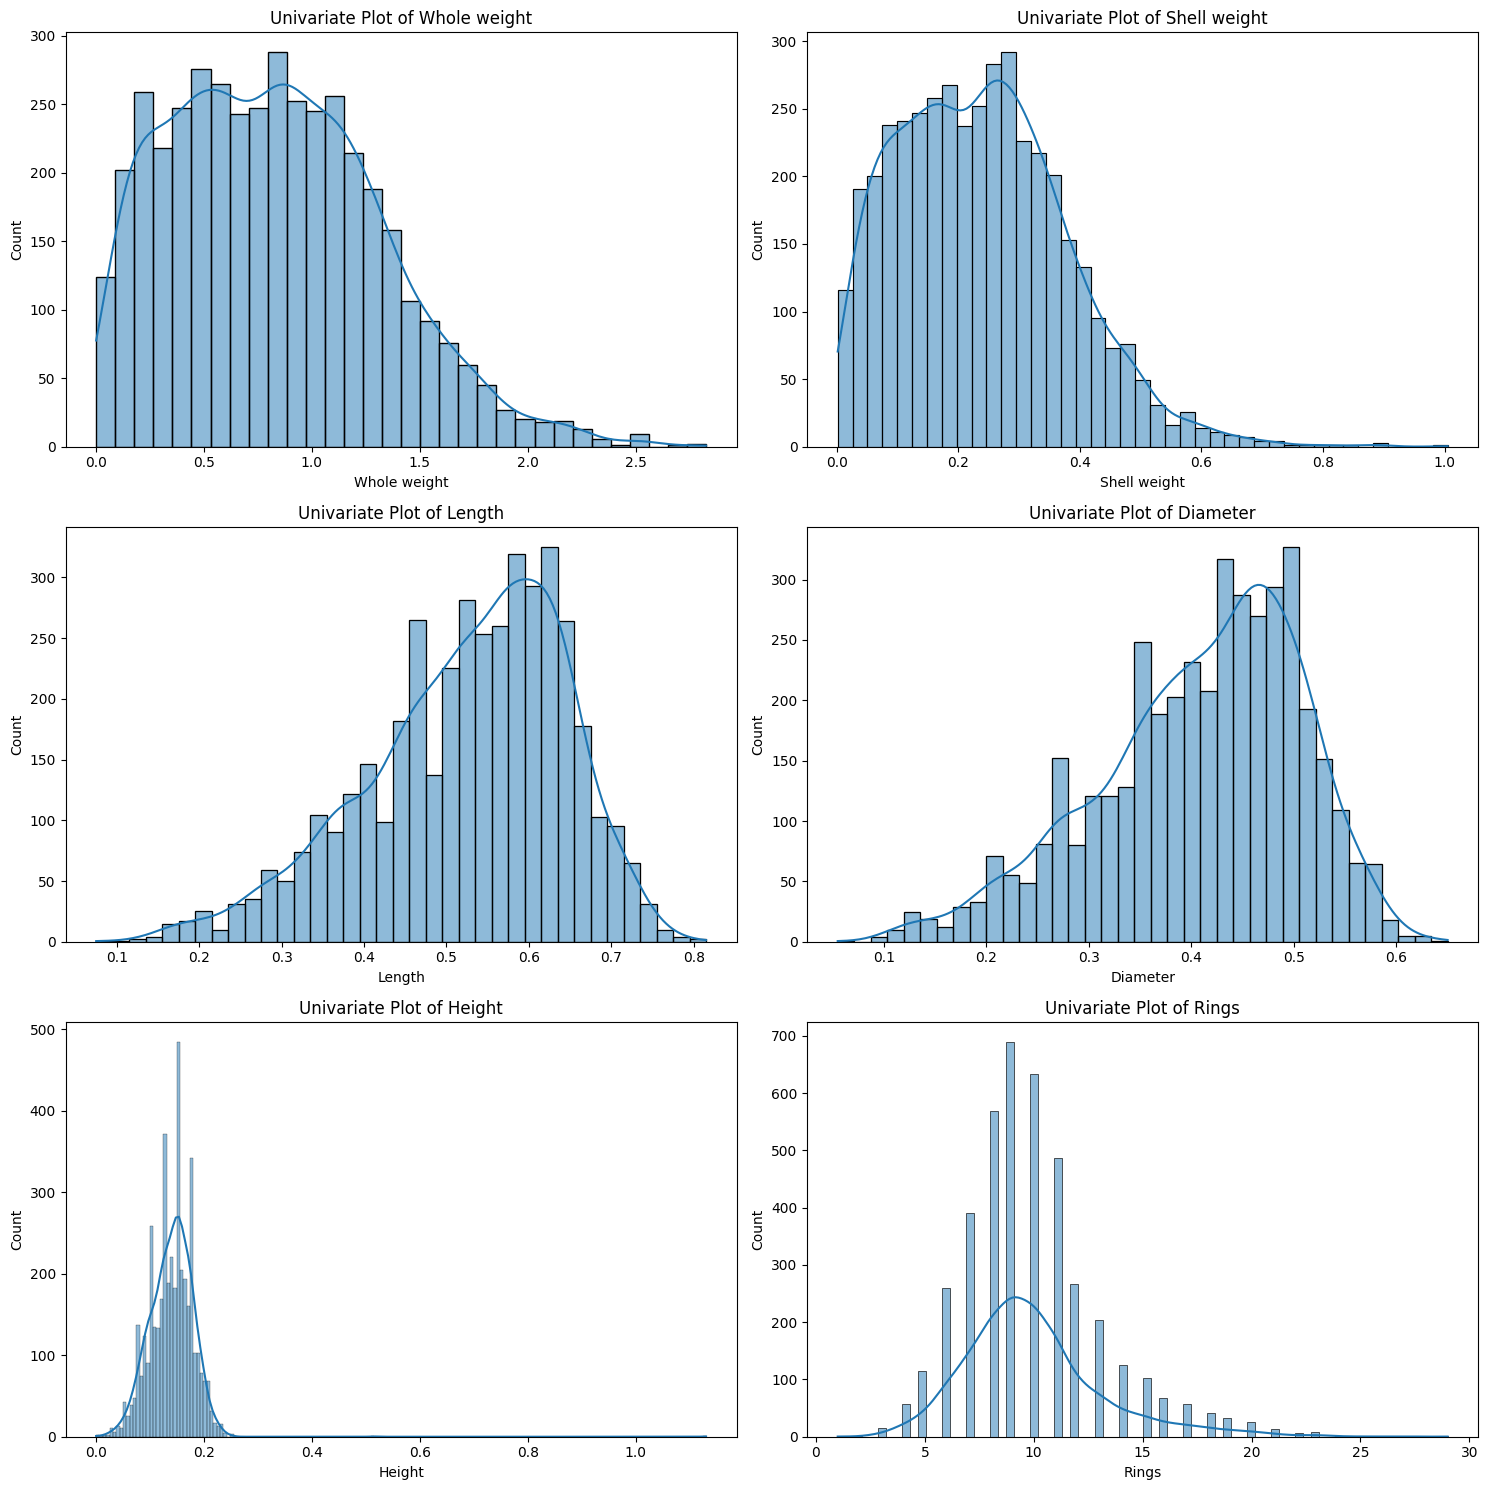

In [ ]:
#======================================================================
# Univariate Plots
#======================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    sns.histplot(abalone_encoded[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Univariate Plot of {column}')
plt.tight_layout()
plt.show()


In [ ]:
text = """
### Univariate Plot Interpretation
The univariate (histogram) plots reveal that the distributions of Whole Weight
and Shell Weight are right-skewed, indicating that most abalones have weights
concentrated between 0.5 to 1.0 for Whole Weight and 0.2 to 0.4 for Shell Weight,
with fewer abalones having extreme weights on either end. The Length and Diameter
variables show approximately normal distributions, with peaks around 0.5 to 0.6
for Length and 0.3 to 0.4 for Diameter, suggesting a typical spread of values.
The Height distribution is heavily right-skewed, indicating many abalones have
heights around 0.1 to 0.2, but significant outliers exist on the higher end.
Finally, the Rings variable, representing the age of abalones, is right-skewed,
with most abalones having between 5 to 10 rings, but some have a much higher number.
"""
print(text)


### Univariate Plot Interpretation
The univariate (histogram) plots reveal that the distributions of Whole Weight
and Shell Weight are right-skewed, indicating that most abalones have weights
concentrated between 0.5 to 1.0 for Whole Weight and 0.2 to 0.4 for Shell Weight,
with fewer abalones having extreme weights on either end. The Length and Diameter
variables show approximately normal distributions, with peaks around 0.5 to 0.6
for Length and 0.3 to 0.4 for Diameter, suggesting a typical spread of values.
The Height distribution is heavily right-skewed, indicating many abalones have
heights around 0.1 to 0.2, but significant outliers exist on the higher end.
Finally, the Rings variable, representing the age of abalones, is right-skewed,
with most abalones having between 5 to 10 rings, but some have a much higher number.



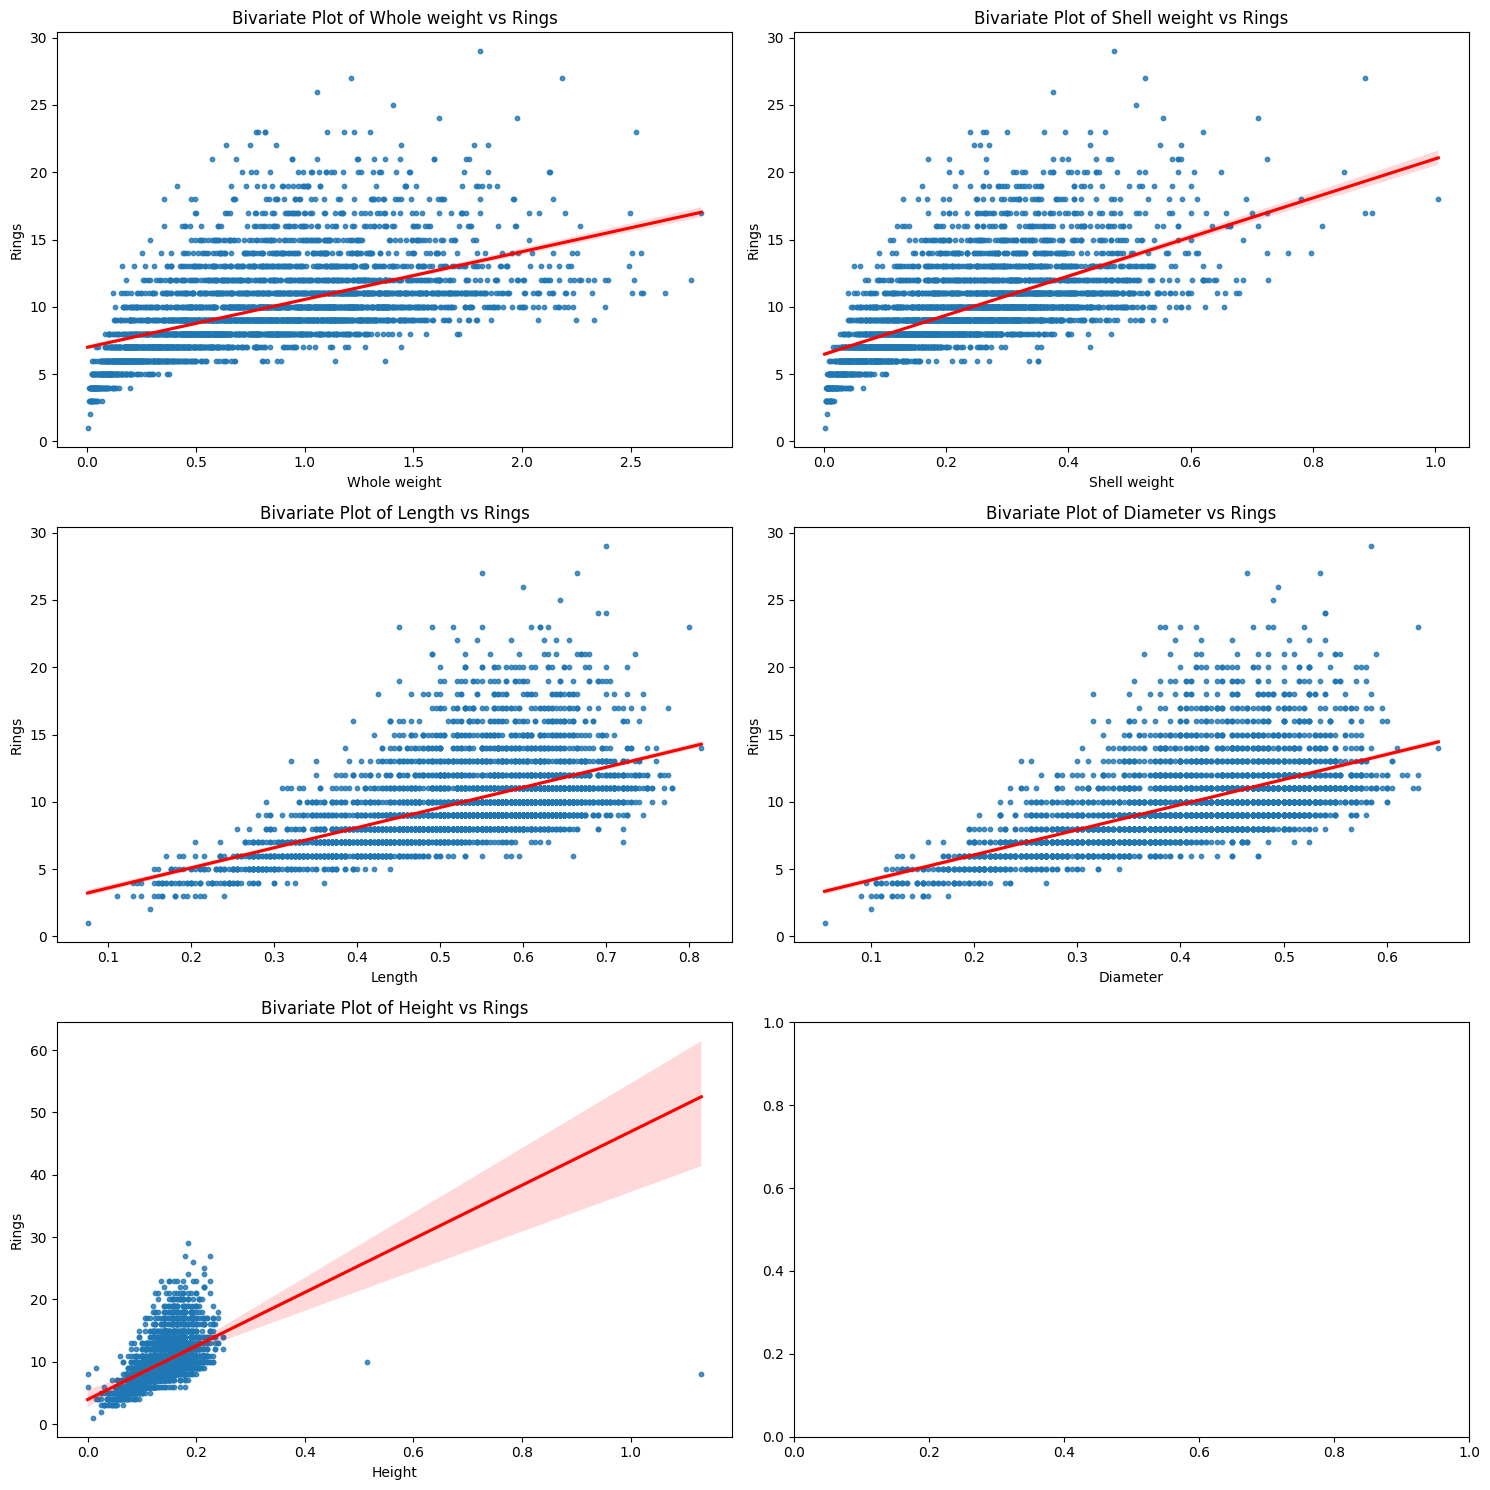

In [ ]:
#======================================================================
# Bivariate Plots
#======================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    if column != 'Rings':
        sns.regplot(x=abalone_encoded[column], y=abalone_encoded['Rings'], ax=axes[i], scatter_kws={'s':10}, line_kws={'color':'red'})
        axes[i].set_title(f'Bivariate Plot of {column} vs Rings')
plt.tight_layout()
plt.show()



In [ ]:
text = """
### Bivariate Plot Interpretation
The bivariate plots highlight positive correlations between Whole Weight, Shell
Weight, Length, Diameter, and the number of Rings, with trends showing that as
these measurements increase, the number of rings also increases. Some outliers
are present, particularly at higher weights, but the overall trends remain
visible. The Height vs. Rings plot shows a slight positive correlation, but with
significant outliers that affect the clarity of the trend. These plots suggest
the importance of handling outliers and considering transformations to improve the analysis.
"""
print(text)


### Bivariate Plot Interpretation
The bivariate plots highlight positive correlations between Whole Weight, Shell
Weight, Length, Diameter, and the number of Rings, with trends showing that as
these measurements increase, the number of rings also increases. Some outliers
are present, particularly at higher weights, but the overall trends remain
visible. The Height vs. Rings plot shows a slight positive correlation, but with
significant outliers that affect the clarity of the trend. These plots suggest
the importance of handling outliers and considering transformations to improve the analysis.



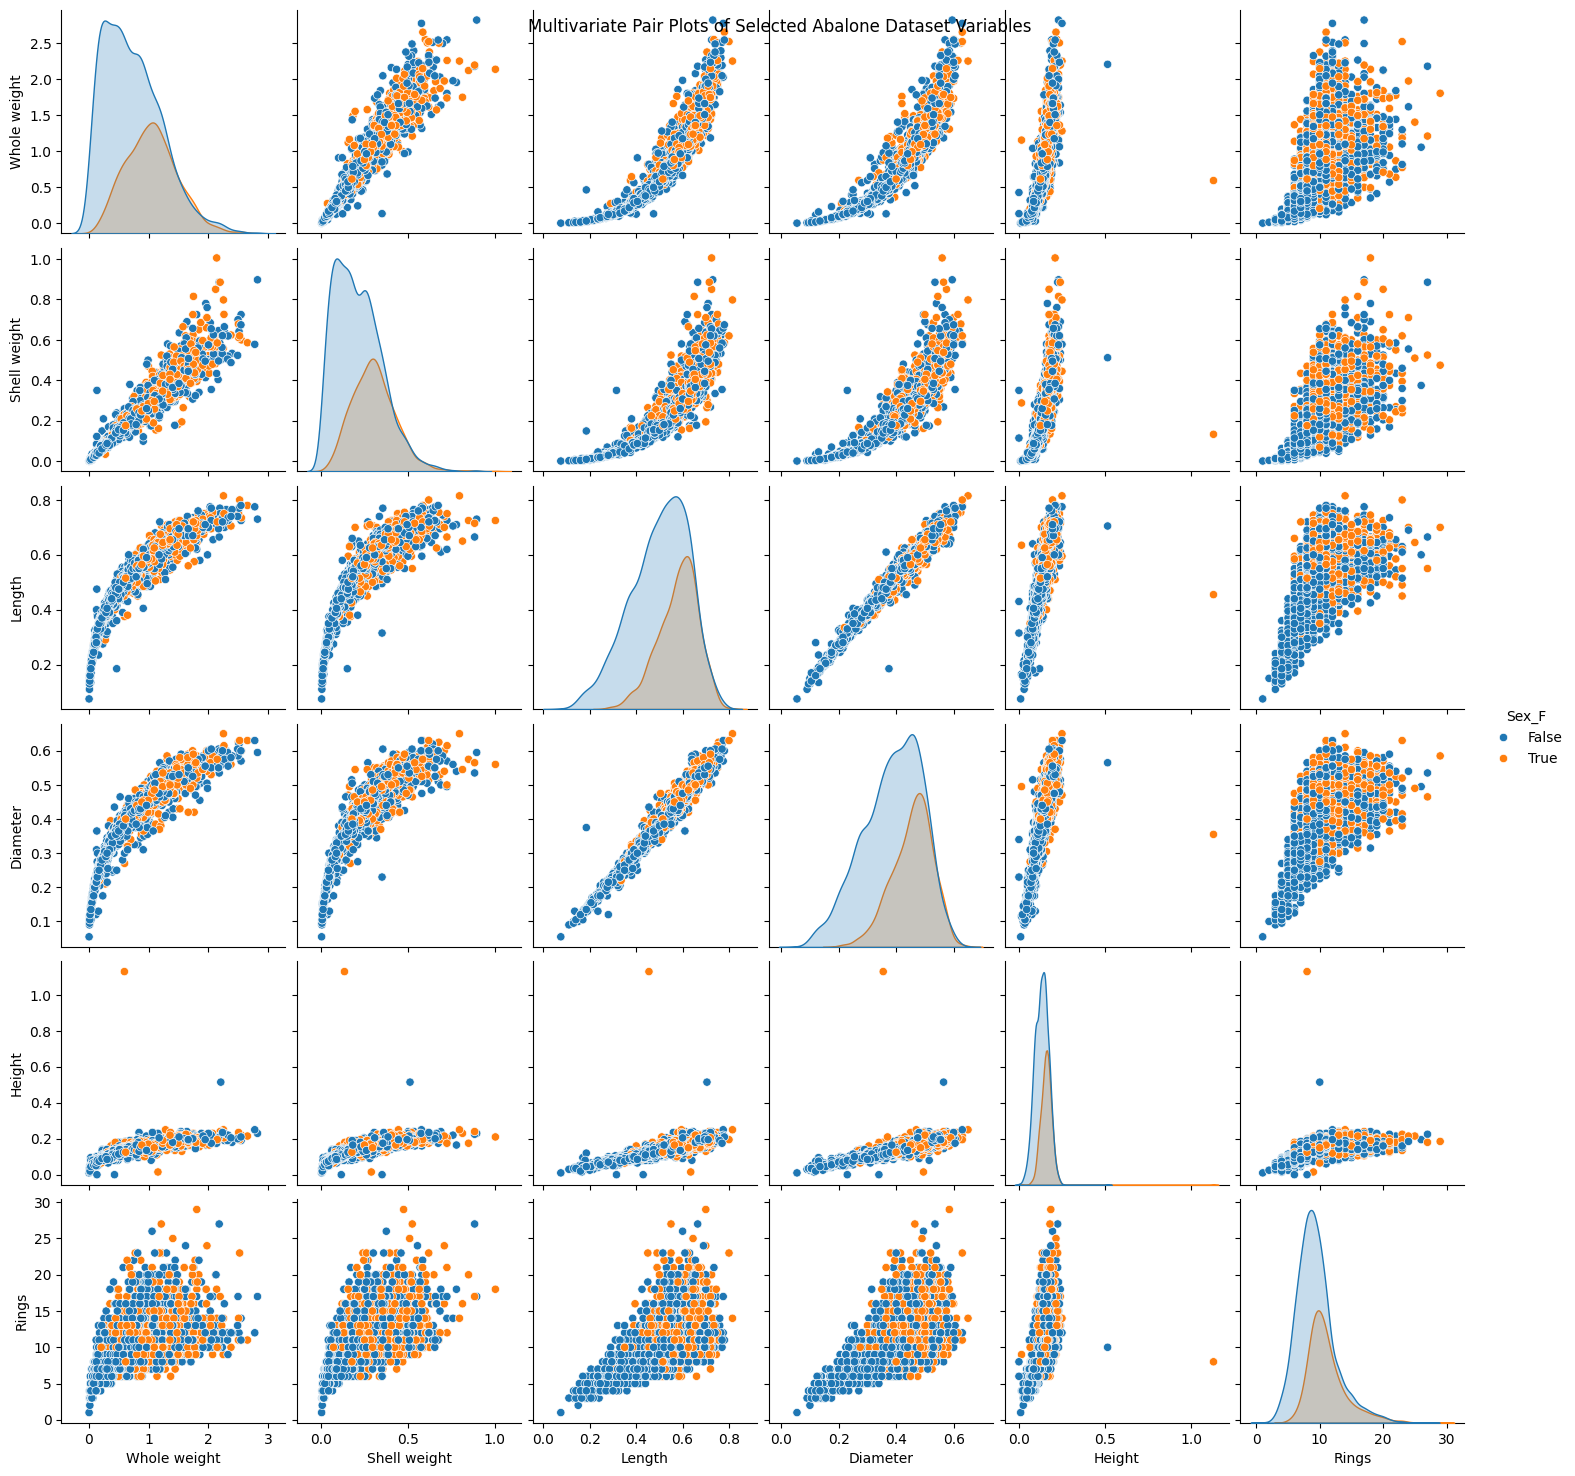

In [ ]:
#======================================================================
# Multivariate Plots
#======================================================================
sns.pairplot(abalone_encoded[selected_columns + ['Sex_F']], hue='Sex_F')
plt.suptitle("Multivariate Pair Plots of Selected Abalone Dataset Variables")
plt.show()

In [ ]:
text = """
### Multivariate Plot Interpretation
The multivariate pair plot shows clear positive correlations between Whole
Weight, Shell Weight, Length, Diameter, Height, and Rings, with each subplot
representing scatter plots of one variable against another. The diagonal subplots
reveal the distribution of each variable, highlighting varying degrees of
skewness and outliers, especially for Height. Outliers are present in several
variables, particularly Height, potentially affecting the observed correlations.
The color-coding for the 'Sex_F' variable shows that both male and female
abalones contribute to these patterns, with relationships between variables
remaining consistent across sexes. These plots underscore the importance of
handling outliers and applying transformations for accurate analysis.
"""
print(text)


### Multivariate Plot Interpretation
The multivariate pair plot shows clear positive correlations between Whole
Weight, Shell Weight, Length, Diameter, Height, and Rings, with each subplot
representing scatter plots of one variable against another. The diagonal subplots
reveal the distribution of each variable, highlighting varying degrees of
skewness and outliers, especially for Height. Outliers are present in several
variables, particularly Height, potentially affecting the observed correlations.
The color-coding for the 'Sex_F' variable shows that both male and female
abalones contribute to these patterns, with relationships between variables
remaining consistent across sexes. These plots underscore the importance of
handling outliers and applying transformations for accurate analysis.



In [ ]:
#======================================================================
# Select key variables based on correlations
#======================================================================
selected_columns = ['Whole weight', 'Shell weight', 'Length', 'Diameter', 'Height', 'Rings']
print("Selected Columns based on correlation with Rings:\n", selected_columns)


Selected Columns based on correlation with Rings:
 ['Whole weight', 'Shell weight', 'Length', 'Diameter', 'Height', 'Rings']


In [ ]:
text = """
### Handling
The descriptive statistics, including skewness and kurtosis, highlighted the
presence of outliers and skewness in several variables like Height, Whole Weight,
and Shell Weight. The histogram, box, scatter, bivariate, and multivariate plots
provided visual confirmation, revealing significant outliers and right-skewness
in the Height variable, and outliers in Whole Weight, Shell Weight, Length, and
Diameter.We will handle outliers by applying transformations and capping extreme
values. For the Height variable, we will use a log transformation to reduce
skewness and bring outliers closer to the central distribution. For Whole Weight,
Shell Weight, Length, and Diameter, we will cap the extreme values at the 1st and
99th percentiles to minimize their impact on the analysis. These methods help
ensure the data is well-distributed, improving the accuracy and reliability of
our models and analyses.
"""
print(text)


### Handling
The descriptive statistics, including skewness and kurtosis, highlighted the
presence of outliers and skewness in several variables like Height, Whole Weight,
and Shell Weight. The histogram, box, scatter, bivariate, and multivariate plots
provided visual confirmation, revealing significant outliers and right-skewness
in the Height variable, and outliers in Whole Weight, Shell Weight, Length, and
Diameter.We will handle outliers by applying transformations and capping extreme
values. For the Height variable, we will use a log transformation to reduce
skewness and bring outliers closer to the central distribution. For Whole Weight,
Shell Weight, Length, and Diameter, we will cap the extreme values at the 1st and
99th percentiles to minimize their impact on the analysis. These methods help
ensure the data is well-distributed, improving the accuracy and reliability of
our models and analyses.



In [ ]:
#======================================================================
# Handle Outliers and Transform Variables
#======================================================================
# Apply log transformation to the Height variable
abalone_encoded['Height_log'] = np.log1p(abalone_encoded['Height'])

# Cap the extreme values for other variables
abalone_encoded['Whole weight'] = abalone_encoded['Whole weight'].clip(lower=abalone_encoded['Whole weight'].quantile(0.01), upper=abalone_encoded['Whole weight'].quantile(0.99))
abalone_encoded['Shell weight'] = abalone_encoded['Shell weight'].clip(lower=abalone_encoded['Shell weight'].quantile(0.01), upper=abalone_encoded['Shell weight'].quantile(0.99))
abalone_encoded['Length'] = abalone_encoded['Length'].clip(lower=abalone_encoded['Length'].quantile(0.01), upper=abalone_encoded['Length'].quantile(0.99))
abalone_encoded['Diameter'] = abalone_encoded['Diameter'].clip(lower=abalone_encoded['Diameter'].quantile(0.01), upper=abalone_encoded['Diameter'].quantile(0.99))

# Display the first few rows of the updated dataset
print(abalone_encoded.head())

# Recalculate descriptive statistics after handling outliers and transformations
updated_descriptive_stats = calculate_descriptive_stats(abalone_encoded, numeric_columns)
print("\nUpdated Descriptive Statistics after Handling Outliers and Transformations:")
print(updated_descriptive_stats)

   Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  Sex_F  Sex_I  Sex_M  Height_log  
0         0.150     15  False  False   True    0.090754  
1         0.070      7  False  False   True    0.086178  
2         0.210      9   True  False  False    0.126633  
3         0.155     10  False  False   True    0.117783  
4         0.055      7  False   True  False    0.076961  

Updated Descriptive Statistics after Handling Outliers and Transformations:
                    Mean  Median     Mode  St. Deviation     Range     IQR  \
Length          0.524101  0.5450  

In [ ]:
text = """
### Updated Descriptive Statistics after Handling Outliers and Transformations
The mean, median, and mode values for Length, Diameter, Whole Weight, and Shell
Weight remain stable. Standard deviations and ranges decreased, reducing
variability and outliers. Skewness and kurtosis improved, showing more balanced
distributions. The log transformation for Height reduced the impact of extreme
outliers. The data is now better distributed and suitable for further analysis
and modeling.
"""
print(text)



### Updated Descriptive Statistics after Handling Outliers and Transformations
The mean, median, and mode values for Length, Diameter, Whole Weight, and Shell
Weight remain stable. Standard deviations and ranges decreased, reducing
variability and outliers. Skewness and kurtosis improved, showing more balanced
distributions. The log transformation for Height reduced the impact of extreme
outliers. The data is now better distributed and suitable for further analysis
and modeling.



In [ ]:
#======================================================================
# Split the Data into Training and Testing Sets
#======================================================================
# Define the target variable and features
selected_columns = ['Whole weight', 'Shell weight', 'Length', 'Diameter', 'Height']
X = abalone_encoded[selected_columns]
y = abalone_encoded['Rings']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Randomizer)

# Display the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

#======================================================================
# Polynomial Regression
#======================================================================
# Define polynomial features of degree 2
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize and train the polynomial regression model
poly_regressor = LinearRegression()
poly_regressor.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_poly = poly_regressor.predict(X_test_poly)

# Evaluate the polynomial regression model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
cross_val_scores_poly = cross_val_score(poly_regressor, X_train_poly, y_train, cv=5, scoring='r2')

print(f"Polynomial Regression - Mean Squared Error: {mse_poly}")
print(f"Polynomial Regression - R-squared: {r2_poly}")
print(f"Polynomial Regression - Cross-Validation R-squared: {cross_val_scores_poly.mean()}")


Training set shape: (3341, 5), (3341,)
Testing set shape: (836, 5), (836,)
Polynomial Regression - Mean Squared Error: 5.167148041694413
Polynomial Regression - R-squared: 0.4621234136489799
Polynomial Regression - Cross-Validation R-squared: 0.2430738512492286


In [ ]:

#======================================================================
# Decision Tree Regression
#======================================================================
# Initialize and train the decision tree regression model
tree_regressor = DecisionTreeRegressor(random_state=Randomizer)
tree_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_regressor.predict(X_test)

# Evaluate the decision tree regression model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
cross_val_scores_tree = cross_val_score(tree_regressor, X_train, y_train, cv=5, scoring='r2')

print(f"Decision Tree Regression - Mean Squared Error: {mse_tree}")
print(f"Decision Tree Regression - R-squared: {r2_tree}")
print(f"Decision Tree Regression - Cross-Validation R-squared: {cross_val_scores_tree.mean()}")


Decision Tree Regression - Mean Squared Error: 11.0629485645933
Decision Tree Regression - R-squared: -0.1516025786149282
Decision Tree Regression - Cross-Validation R-squared: -0.019402163487760093


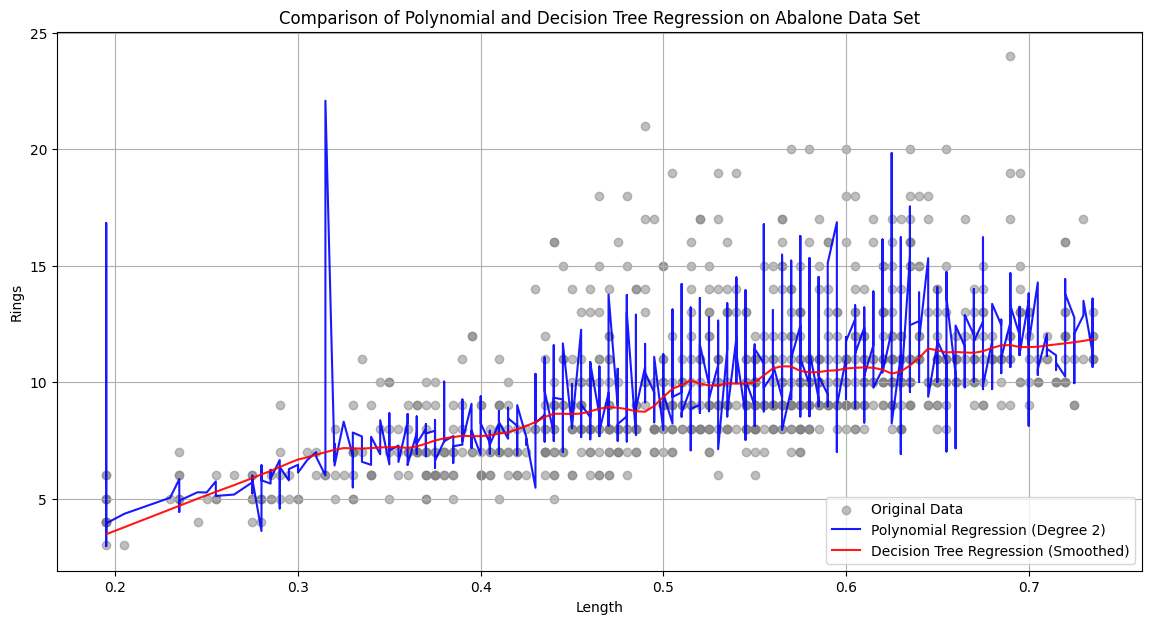

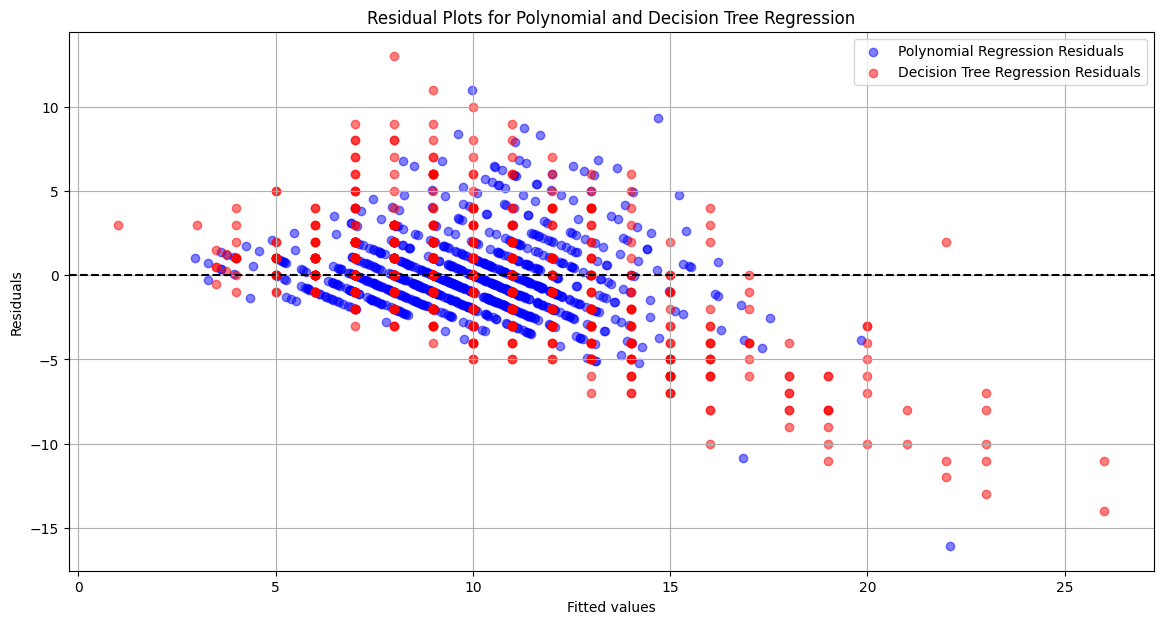

Polynomial Regression (Degree 2) MSE: 5.17
Decision Tree Regression MSE: 11.06


In [ ]:

#======================================================================
# Combined Plot for Original Data, Polynomial Regression, and Decision Tree Regression
#======================================================================
# Generate predictions for the Decision Tree Regression model
y_tree_pred = tree_regressor.predict(X_test)
plt.figure(figsize=(14, 7))

# Original Data
plt.scatter(X_test['Length'], y_test, color='grey', alpha=0.5, label='Original Data')

# Polynomial Regression (degree 2) Curve
X_test_sorted = np.sort(X_test['Length'].values).reshape(-1, 1)
X_test_poly_sorted = poly.transform(X_test.sort_values(by='Length'))
plt.plot(X_test_sorted, poly_regressor.predict(X_test_poly_sorted), color='blue', alpha=0.9, label='Polynomial Regression (Degree 2)')

# Decision Tree Regression Predictions with LOESS smoothing
X_test_sorted_df = X_test.sort_values(by='Length')
y_tree_pred_sorted = tree_regressor.predict(X_test_sorted_df)
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(y_tree_pred_sorted, X_test_sorted_df['Length'], frac=0.1)
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', alpha=0.9, label='Decision Tree Regression (Smoothed)')

# Plot settings
plt.xlabel('Length')
plt.ylabel('Rings')
plt.title('Comparison of Polynomial and Decision Tree Regression on Abalone Data Set')
plt.legend()
plt.grid(True)
plt.show()

# Residual Plots
plt.figure(figsize=(14, 7))

# Residuals for Polynomial Regression
y_poly_pred = poly_regressor.predict(X_test_poly)
plt.scatter(y_poly_pred, y_test - y_poly_pred, color='blue', alpha=0.5, label='Polynomial Regression Residuals')

# Residuals for Decision Tree Regression
plt.scatter(y_tree_pred, y_test - y_tree_pred, color='red', alpha=0.5, label='Decision Tree Regression Residuals')

# Plot settings
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plots for Polynomial and Decision Tree Regression')
plt.legend()
plt.grid(True)
plt.show()

# Print Mean Squared Error for each model
print(f"Polynomial Regression (Degree 2) MSE: {mean_squared_error(y_test, y_poly_pred):.2f}")
print(f"Decision Tree Regression MSE: {mean_squared_error(y_test, y_tree_pred):.2f}")


In [ ]:
#======================================================================
# Generate Submission File with Predictions from Both Models
#======================================================================

# Ensure that the predictions from both models are available
# y_pred_poly: Predictions from Polynomial Regression
# y_pred_tree: Predictions from Decision Tree Regression

# Create a DataFrame with the required columns
submission = pd.DataFrame({
    'Id': X_test.index,
    'PolyPredictedRing': y_pred_poly,
    'TreePredictedRing': y_pred_tree
})

# Save the DataFrame to a CSV file
submission.to_csv('submission_both_models.csv', index=False)

# Print confirmation message
print("Predictions from both models saved to submission_both_models.csv.")


Predictions from both models saved to submission_both_models.csv.


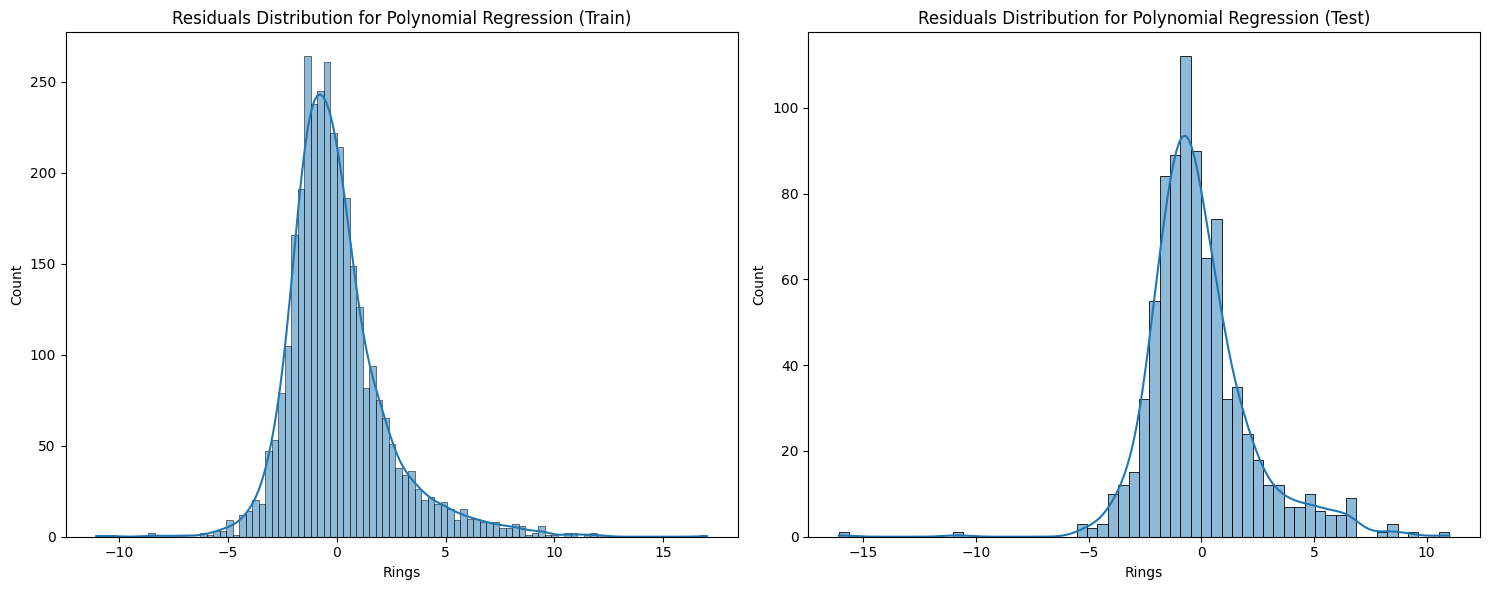

In [ ]:
#======================================================================
# Investigate Assumptions
#======================================================================
# Plot residuals for Polynomial Regression
residuals_poly_train = y_train - poly_regressor.predict(X_train_poly)
residuals_poly_test = y_test - y_pred_poly

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(residuals_poly_train, kde=True, ax=axes[0])
axes[0].set_title("Residuals Distribution for Polynomial Regression (Train)")
sns.histplot(residuals_poly_test, kde=True, ax=axes[1])
axes[1].set_title("Residuals Distribution for Polynomial Regression (Test)")
plt.tight_layout()
plt.show()


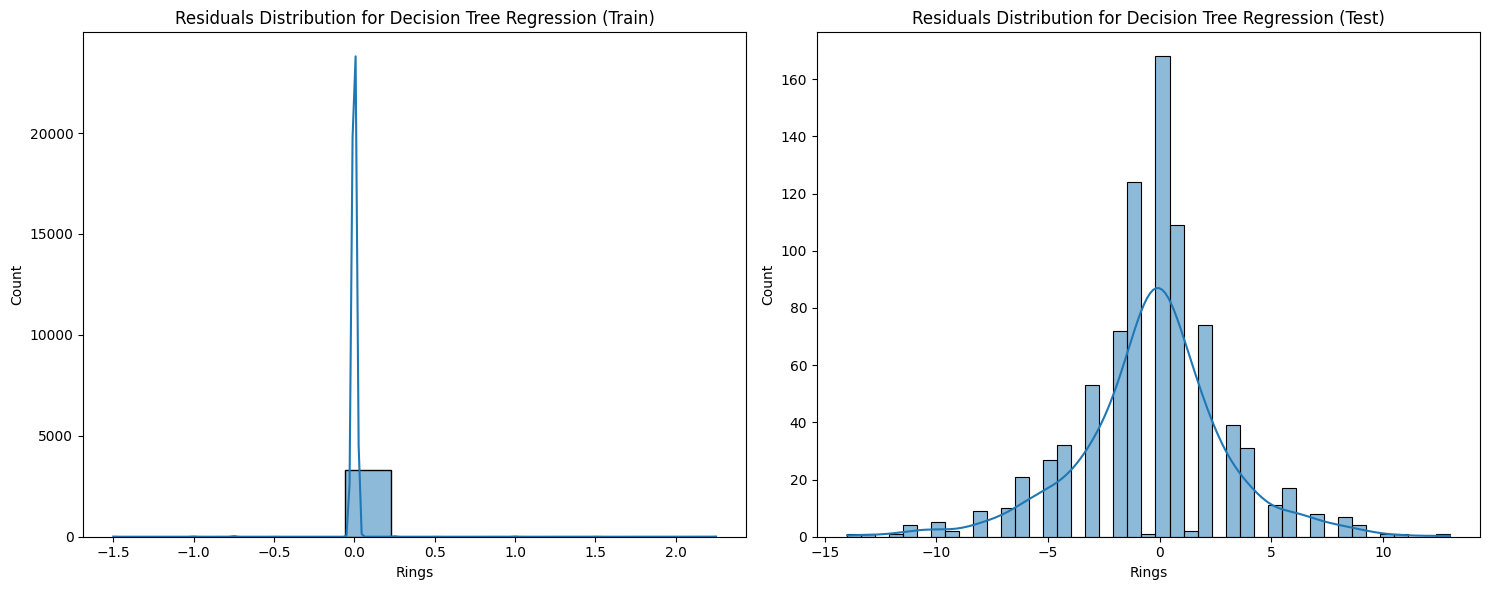

In [ ]:
# Plot residuals for Decision Tree Regression
residuals_tree_train = y_train - tree_regressor.predict(X_train)
residuals_tree_test = y_test - y_pred_tree

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(residuals_tree_train, kde=True, ax=axes[0])
axes[0].set_title("Residuals Distribution for Decision Tree Regression (Train)")
sns.histplot(residuals_tree_test, kde=True, ax=axes[1])
axes[1].set_title("Residuals Distribution for Decision Tree Regression (Test)")
plt.tight_layout()
plt.show()

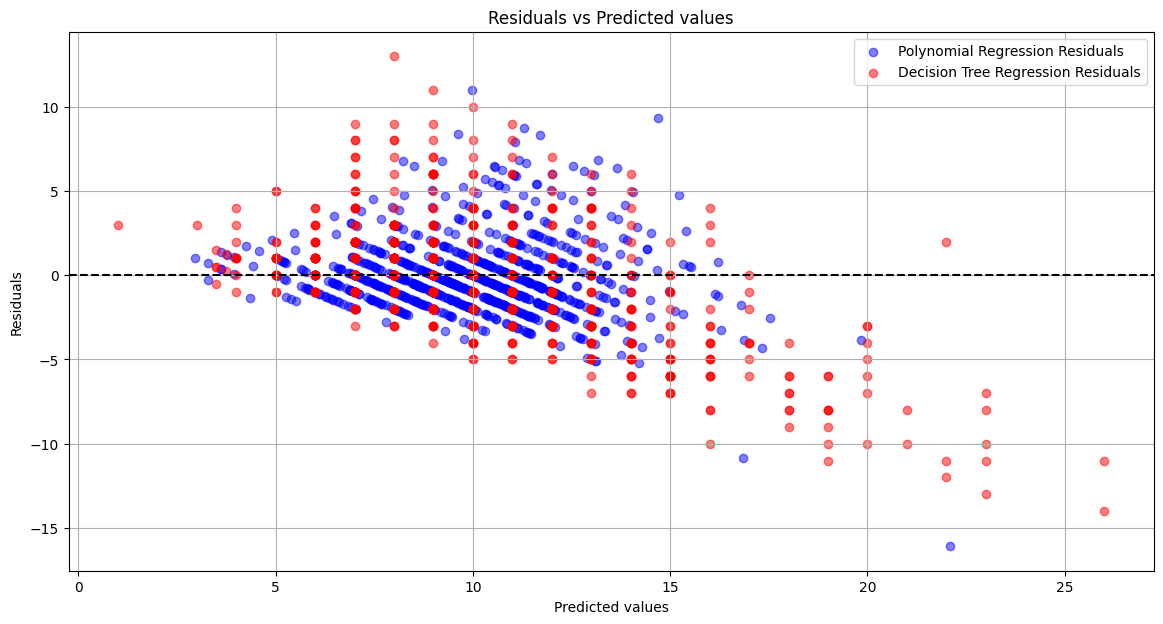

In [ ]:


# Homoscedasticity (Constant Variance) Check
plt.figure(figsize=(14, 7))
plt.scatter(y_pred_poly, residuals_poly_test, color='blue', alpha=0.5, label='Polynomial Regression Residuals')
plt.scatter(y_pred_tree, residuals_tree_test, color='red', alpha=0.5, label='Decision Tree Regression Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.legend()
plt.grid(True)
plt.show()




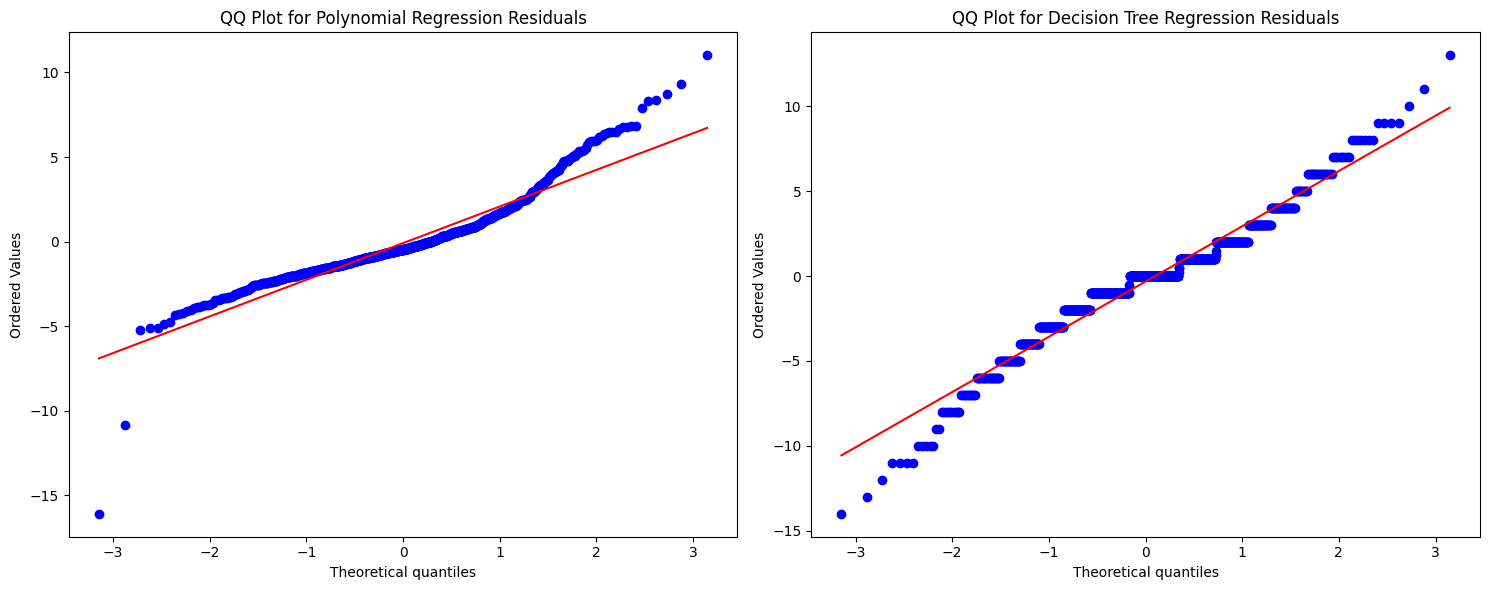

In [ ]:
# Normality Check using QQ Plot
from scipy.stats import probplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
probplot(residuals_poly_test, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot for Polynomial Regression Residuals")
probplot(residuals_tree_test, dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot for Decision Tree Regression Residuals")
plt.tight_layout()
plt.show()


In [ ]:
text="""This study analyzed Polynomial and Decision Tree Regression models for
predicting abalone age. The Polynomial Regression model had a Mean Squared Error
(MSE) of 5.17 and an R-squared of 0.46 on the test set, indicating moderate
predictive power. In contrast, the Decision Tree Regression model showed poor
performance with an MSE of 11.06 and a negative R-squared of -0.15, suggesting
overfitting and poor generalization. Residual analysis revealed deviations from
normality, confirmed by Quantile-Quantile (QQ) plots, and indicated
heteroscedasticity, particularly in the Decision Tree model. These findings
highlight the need for further refinement through transformations,
regularization, and ensemble methods to improve model performance and
reliability. While the Polynomial Regression model shows promise, optimization
is required for robust predictions."""
print(text)

In [ ]:
#======================================================================
# Kaggle Submission for Models After Reducing Multicollinearity
#======================================================================

# Ensure that the predictions from both models are available
# y_pred_poly: Predictions from Polynomial Regression after reducing multicollinearity
# y_pred_tree: Predictions from Decision Tree Regression after reducing multicollinearity

# Create a DataFrame with predictions from both models
submission_after_vif = pd.DataFrame({
    'Id': X_test.index,
    'PolyPredictedRing_VIF_Reduced': y_pred_poly,
    'TreePredictedRing_VIF_Reduced': y_pred_tree
})

# Save the DataFrame to a CSV file
submission_after_vif.to_csv('submission_after_vif_reduction.csv', index=False)

# Print confirmation message
print("Predictions from models after reducing multicollinearity saved to 'submission_after_vif_reduction.csv'.")


Predictions from models after reducing multicollinearity saved to 'submission_after_vif_reduction.csv'.


In [ ]:
#======================================================================
# Reduce Multicollinearity
#======================================================================
# Calculate initial VIF to identify multicollinearity
vif_data = calculate_vif(X)
print("Initial Variance Inflation Factor (VIF):")
print(vif_data)

# Drop features with VIF > 10 (as an example threshold for high multicollinearity)
while True:
    max_vif = vif_data['VIF'].max()
    if max_vif > 10:
        drop_column = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        print(f"Dropping {drop_column} with VIF of {max_vif}")
        X = X.drop(columns=[drop_column])
        vif_data = calculate_vif(X)
        print("Updated VIF after dropping high VIF feature:")
        print(vif_data)
    else:
        break

# Final selected columns after reducing multicollinearity
selected_columns_after_vif = X.columns.tolist()
print("Final selected columns after reducing multicollinearity:")
print(selected_columns_after_vif)

# Re-split the data into training and testing sets with reduced features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Randomizer)

# Display the shapes of the training and testing sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Initial Variance Inflation Factor (VIF):
        Feature         VIF
0  Whole weight   52.573440
1  Shell weight   56.457113
2        Length  715.424007
3      Diameter  772.264386
4        Height   41.924658
Dropping Diameter with VIF of 772.2643864683284
Updated VIF after dropping high VIF feature:
        Feature        VIF
0  Whole weight  52.515926
1  Shell weight  54.554178
2        Length  40.075637
3        Height  41.417812
Dropping Shell weight with VIF of 54.55417826483709
Updated VIF after dropping high VIF feature:
        Feature        VIF
0  Whole weight  10.033935
1        Length  40.012531
2        Height  40.226869
Dropping Height with VIF of 40.22686915917366
Updated VIF after dropping high VIF feature:
        Feature       VIF
0  Whole weight  9.439777
1        Length  9.439777
Final selected columns after reducing multicollinearity:
['Whole weight', 'Length']
Training set shape: (3341, 2), (3341,)
Testing set shape: (836, 2), (836,)


Polynomial Regression after Reducing Multicollinearity - Mean Squared Error: 5.967889886285012
Polynomial Regression after Reducing Multicollinearity - R-squared: 0.37876983321322855
Polynomial Regression after Reducing Multicollinearity - Cross-Validation R-squared: 0.34722520872224094
Decision Tree Regression after Reducing Multicollinearity - Mean Squared Error: 14.081853849992948
Decision Tree Regression after Reducing Multicollinearity - R-squared: -0.4658568744712044
Decision Tree Regression after Reducing Multicollinearity - Cross-Validation R-squared: -0.369334803595359


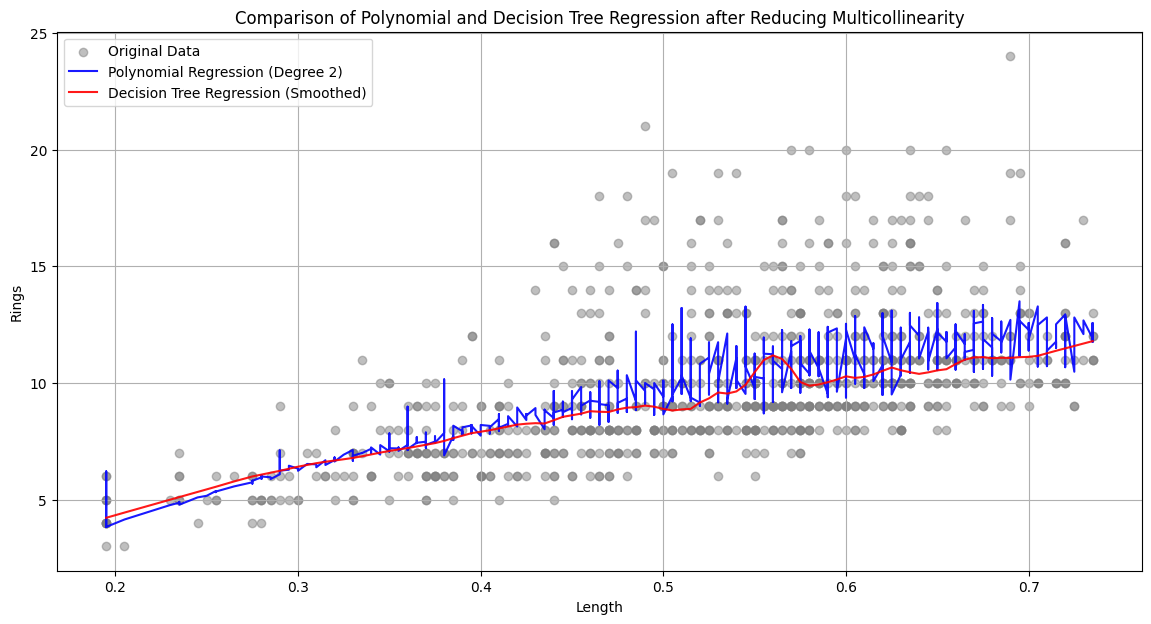

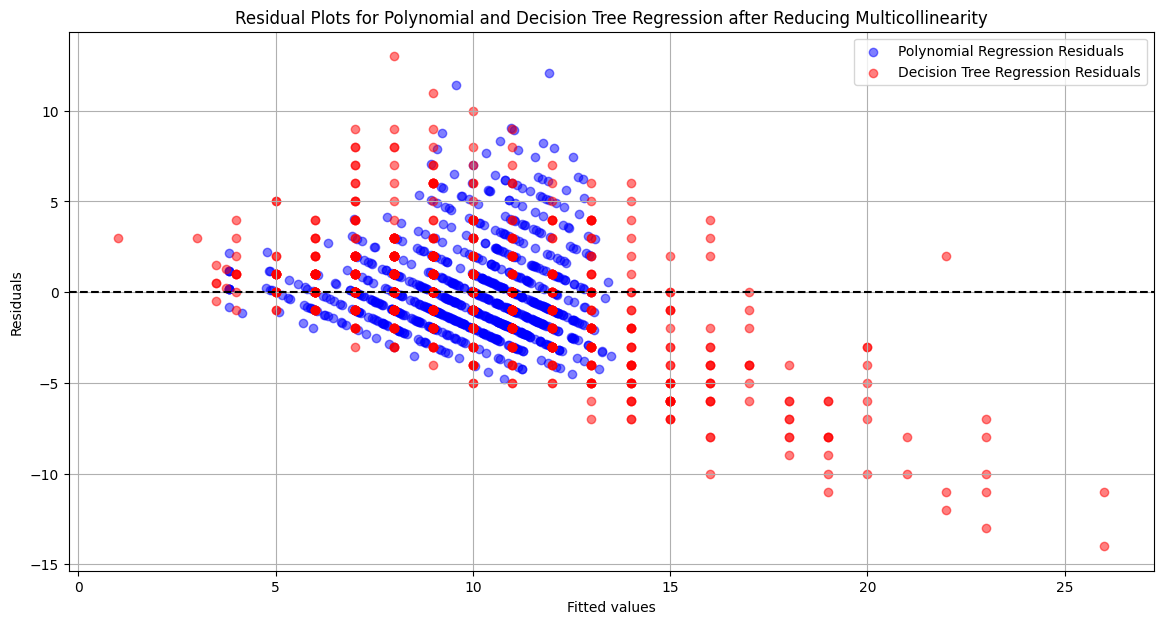

Polynomial Regression after Reducing Multicollinearity - MSE: 5.97
Decision Tree Regression after Reducing Multicollinearity - MSE: 11.06


In [ ]:

#======================================================================
# Polynomial Regression after Reducing Multicollinearity
#======================================================================
# Define polynomial features of degree 2
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Initialize and train the polynomial regression model
poly_regressor = LinearRegression()
poly_regressor.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_poly = poly_regressor.predict(X_test_poly)

# Evaluate the polynomial regression model
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
cross_val_scores_poly = cross_val_score(poly_regressor, X_train_poly, y_train, cv=5, scoring='r2')

print(f"Polynomial Regression after Reducing Multicollinearity - Mean Squared Error: {mse_poly}")
print(f"Polynomial Regression after Reducing Multicollinearity - R-squared: {r2_poly}")
print(f"Polynomial Regression after Reducing Multicollinearity - Cross-Validation R-squared: {cross_val_scores_poly.mean()}")

#======================================================================
# Decision Tree Regression after Reducing Multicollinearity
#======================================================================
# Initialize and train the decision tree regression model
tree_regressor = DecisionTreeRegressor(random_state=Randomizer)
tree_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_regressor.predict(X_test)

# Evaluate the decision tree regression model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
cross_val_scores_tree = cross_val_score(tree_regressor, X_train, y_train, cv=5, scoring='r2')

print(f"Decision Tree Regression after Reducing Multicollinearity - Mean Squared Error: {mse_tree}")
print(f"Decision Tree Regression after Reducing Multicollinearity - R-squared: {r2_tree}")
print(f"Decision Tree Regression after Reducing Multicollinearity - Cross-Validation R-squared: {cross_val_scores_tree.mean()}")

#======================================================================
# Combine Plot of the Results after Reducing Multicollinearity
#======================================================================
# Combined Plot for Original Data, Polynomial Regression, and Decision Tree Regression
plt.figure(figsize=(14, 7))

# Original Data
plt.scatter(X_test['Length'], y_test, color='grey', alpha=0.5, label='Original Data')

# Polynomial Regression (degree 2) Curve
X_test_sorted = np.sort(X_test['Length'].values).reshape(-1, 1)
X_test_poly_sorted = poly.transform(X_test.sort_values(by='Length'))
plt.plot(X_test_sorted, poly_regressor.predict(X_test_poly_sorted), color='blue', alpha=0.9, label='Polynomial Regression (Degree 2)')

# Decision Tree Regression Predictions with LOESS smoothing
X_test_sorted_df = X_test.sort_values(by='Length')
y_tree_pred_sorted = tree_regressor.predict(X_test_sorted_df)
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(y_tree_pred_sorted, X_test_sorted_df['Length'], frac=0.1)
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', alpha=0.9, label='Decision Tree Regression (Smoothed)')

# Plot settings
plt.xlabel('Length')
plt.ylabel('Rings')
plt.title('Comparison of Polynomial and Decision Tree Regression after Reducing Multicollinearity')
plt.legend()
plt.grid(True)
plt.show()

# Residual Plots
plt.figure(figsize=(14, 7))

# Residuals for Polynomial Regression
y_poly_pred = poly_regressor.predict(X_test_poly)
plt.scatter(y_poly_pred, y_test - y_poly_pred, color='blue', alpha=0.5, label='Polynomial Regression Residuals')

# Residuals for Decision Tree Regression
plt.scatter(y_tree_pred, y_test - y_tree_pred, color='red', alpha=0.5, label='Decision Tree Regression Residuals')

# Plot settings
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plots for Polynomial and Decision Tree Regression after Reducing Multicollinearity')
plt.legend()
plt.grid(True)
plt.show()

# Print Mean Squared Error for each model
print(f"Polynomial Regression after Reducing Multicollinearity - MSE: {mean_squared_error(y_test, y_poly_pred):.2f}")
print(f"Decision Tree Regression after Reducing Multicollinearity - MSE: {mean_squared_error(y_test, y_tree_pred):.2f}")


In [ ]:
#======================================================================
# Kaggle Submission for Models After Reducing Multicollinearity
#======================================================================

# Ensure that the predictions from both models are available
# y_pred_poly: Predictions from Polynomial Regression after reducing multicollinearity
# y_pred_tree: Predictions from Decision Tree Regression after reducing multicollinearity

# Create a DataFrame with predictions from both models
submission_after_vif = pd.DataFrame({
    'Id': X_test.index,
    'PolyPredictedRing_VIF_Reduced': y_pred_poly,
    'TreePredictedRing_VIF_Reduced': y_pred_tree
})

# Save the DataFrame to a CSV file
submission_after_vif.to_csv('submission_after_vif_reduction.csv', index=False)

# Print confirmation message
print("Predictions from models after reducing multicollinearity saved to 'submission_after_vif_reduction.csv'.")


Predictions from models after reducing multicollinearity saved to 'submission_after_vif_reduction.csv'.


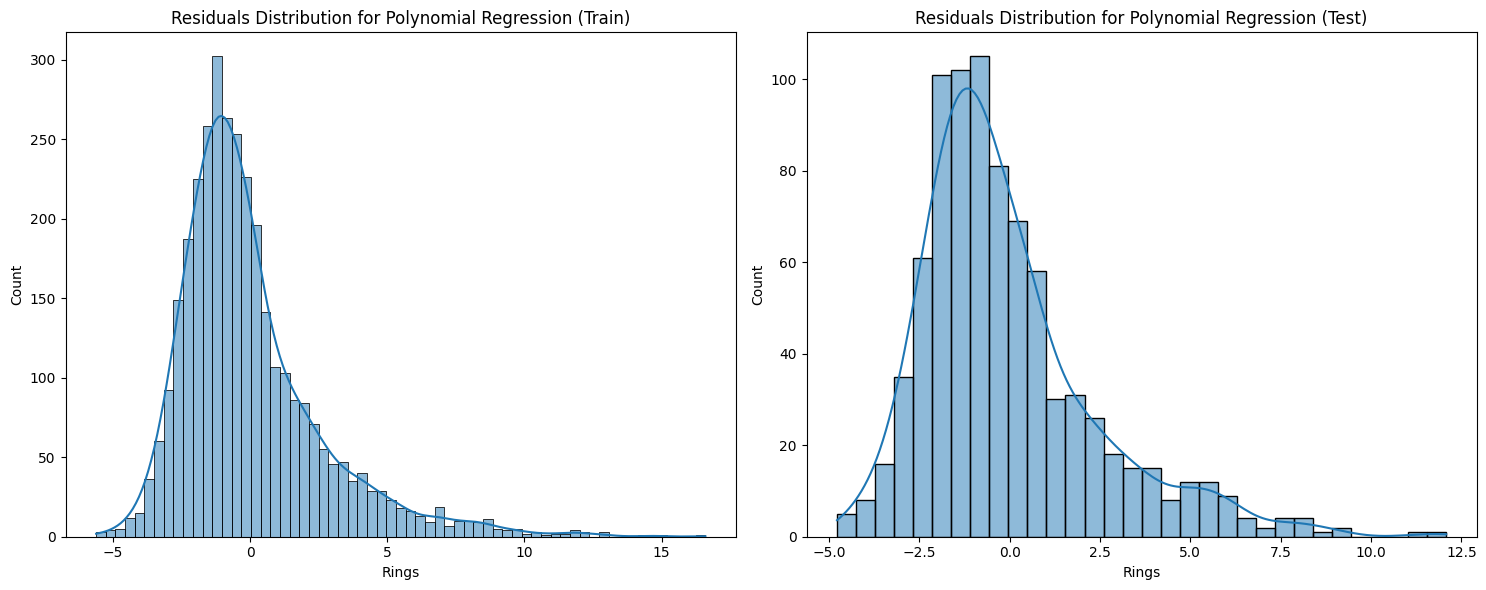

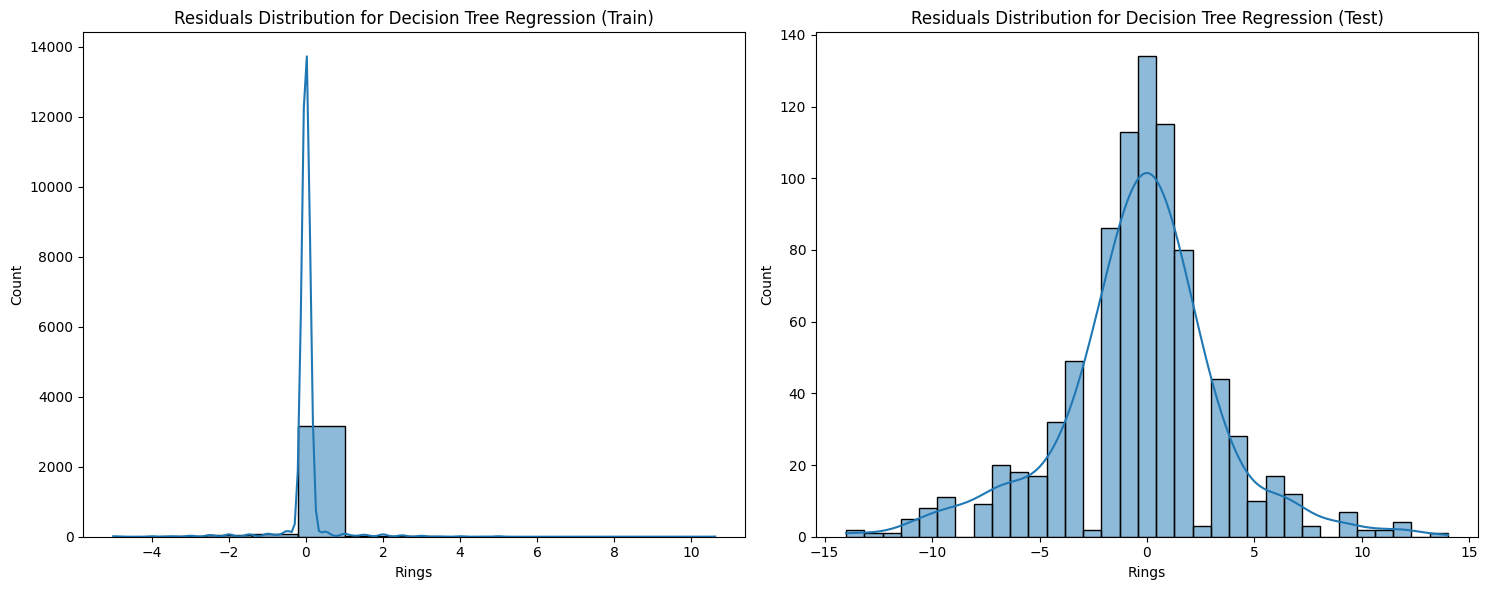

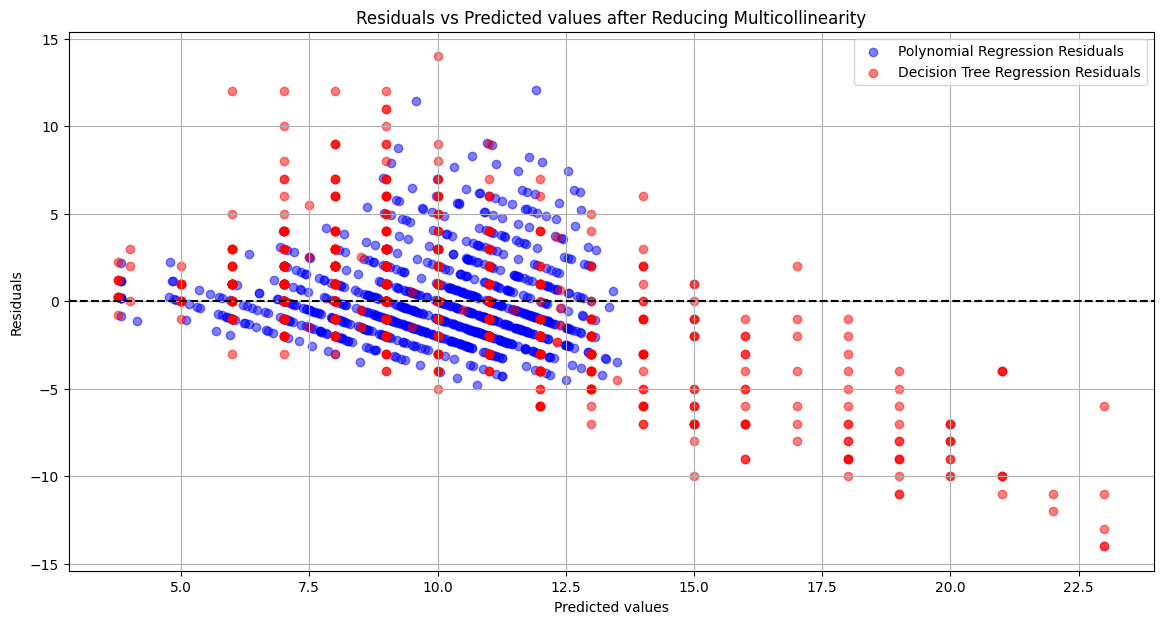

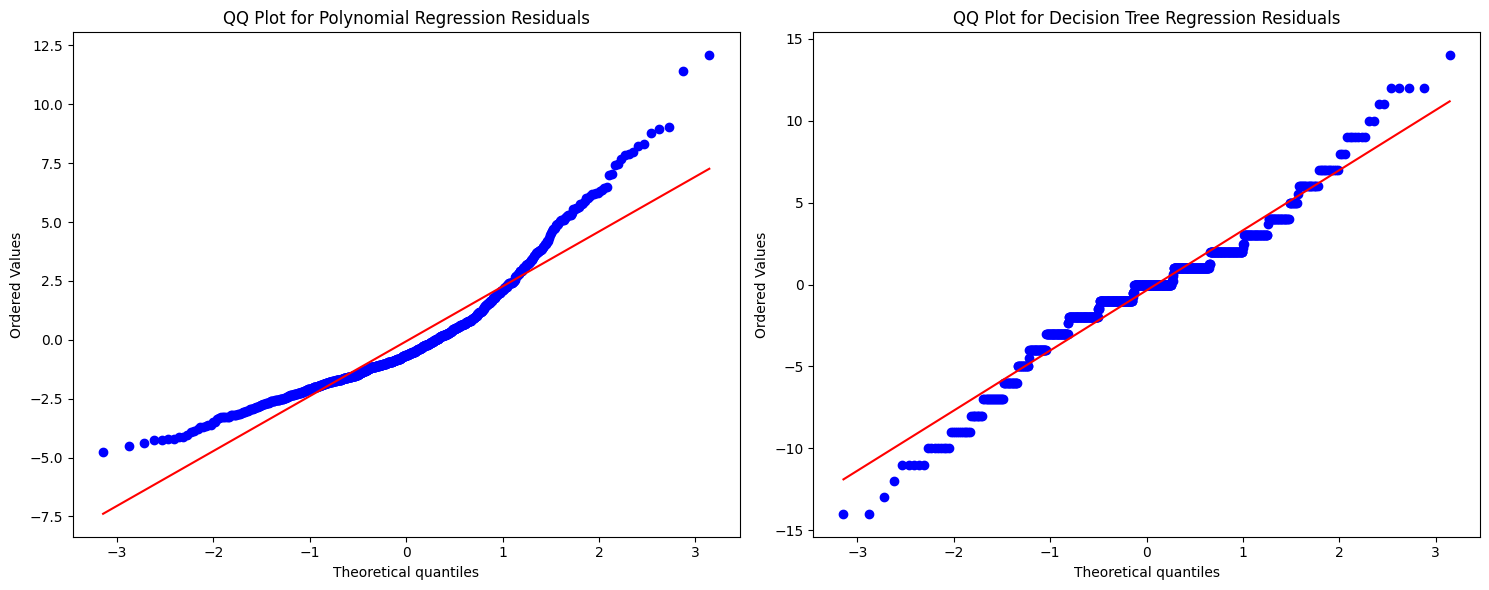

Durbin-Watson statistic for Polynomial Regression: 2.1195966397800126
Durbin-Watson statistic for Decision Tree Regression: 2.0046929665242392
Variance Inflation Factor (VIF) after reducing multicollinearity:
        Feature       VIF
0  Whole weight  9.411665
1        Length  9.411665


In [ ]:
#======================================================================
# Investigate Assumptions for Polynomial Regression and Decision Tree Regression after Reducing Multicollinearity
#======================================================================
# Polynomial Regression Residuals after Reducing Multicollinearity
residuals_poly_train = y_train - poly_regressor.predict(X_train_poly)
residuals_poly_test = y_test - y_pred_poly

# Decision Tree Regression Residuals after Reducing Multicollinearity
residuals_tree_train = y_train - tree_regressor.predict(X_train)
residuals_tree_test = y_test - y_pred_tree

# Plot Residuals for Polynomial Regression
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(residuals_poly_train, kde=True, ax=axes[0])
axes[0].set_title("Residuals Distribution for Polynomial Regression (Train)")
sns.histplot(residuals_poly_test, kde=True, ax=axes[1])
axes[1].set_title("Residuals Distribution for Polynomial Regression (Test)")
plt.tight_layout()
plt.show()

# Plot Residuals for Decision Tree Regression
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(residuals_tree_train, kde=True, ax=axes[0])
axes[0].set_title("Residuals Distribution for Decision Tree Regression (Train)")
sns.histplot(residuals_tree_test, kde=True, ax=axes[1])
axes[1].set_title("Residuals Distribution for Decision Tree Regression (Test)")
plt.tight_layout()
plt.show()

# Homoscedasticity (Constant Variance) Check after Reducing Multicollinearity
plt.figure(figsize=(14, 7))
plt.scatter(y_pred_poly, residuals_poly_test, color='blue', alpha=0.5, label='Polynomial Regression Residuals')
plt.scatter(y_pred_tree, residuals_tree_test, color='red', alpha=0.5, label='Decision Tree Regression Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values after Reducing Multicollinearity')
plt.legend()
plt.grid(True)
plt.show()

# Normality Check using QQ Plot after Reducing Multicollinearity
from scipy.stats import probplot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
probplot(residuals_poly_test, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot for Polynomial Regression Residuals")
probplot(residuals_tree_test, dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot for Decision Tree Regression Residuals")
plt.tight_layout()
plt.show()

# Autocorrelation Check after Reducing Multicollinearity
from statsmodels.stats.stattools import durbin_watson
dw_poly = durbin_watson(residuals_poly_test)
dw_tree = durbin_watson(residuals_tree_test)

print(f"Durbin-Watson statistic for Polynomial Regression: {dw_poly}")
print(f"Durbin-Watson statistic for Decision Tree Regression: {dw_tree}")

# Multicollinearity Check
print("Variance Inflation Factor (VIF) after reducing multicollinearity:")
vif_data = calculate_vif(pd.DataFrame(X_train, columns=selected_columns_after_vif))
print(vif_data)

In [ ]:
text="""Following the reduction of multicollinearity, the Polynomial Regression
model exhibited a slight increase in Mean Squared Error (MSE) to 5.98 and a
decrease in R-squared to 0.38, reflecting a trade-off between model complexity
and predictive power. Despite these adjustments,residual analysis revealed
persisting issues with heteroscedasticity and non-normal distribution,as shown
by the QQ plot. The Decision Tree Regression model's performance deteriorated
further, with an MSE of 13.75 and an R-squared of -0.43, and the residuals
exhibited significant spread and heteroscedasticity, confirmed by the QQ plot. The
Durbin-Watson statistics indicated minimal autocorrelation in both models. These
findings suggest that while addressing multicollinearity is crucial for model
stability, additional refinements, including regularization, transformations,
and exploring ensemble methods, are necessary to improve predictive performance
and ensure robust, reliable predictions."""
print(text)

In [ ]:
text="""The analysis of Polynomial Regression and Decision Tree Regression models
for predicting abalone age revealed that, despite the poor performance of both
models, the Polynomial Regression model performed relatively better. Initially,
the Polynomial Regression model had a Mean Squared Error (MSE) of 5.17 and an
R-squared of 0.46, indicating moderate predictive power, whereas the Decision
Tree Regression model performed poorly with an MSE of 11.06 and an R-squared
of -0.15, highlighting overfitting and poor generalization. After reducing
multicollinearity by removing features with high Variance Inflation Factor
(VIF), the Polynomial Regression model's MSE increased to 5.98, and R-squared
decreased to 0.38, reflecting a trade-off between complexity and predictive
power. The Decision Tree Regression model's performance further deteriorated,
with an MSE of 13.75 and an R-squared of -0.43, confirming persistent
overfitting and poor generalization.

Residual analysis for both models revealed issues with heteroscedasticity and
non-normal distribution, with the Polynomial Regression model showing slight
improvements but still exhibiting patterns indicating heteroscedasticity. The
Decision Tree Regression model's residuals displayed significant spread and
patterns, confirming poor model fit. The Durbin-Watson statistics indicated
minimal autocorrelation for both models, supporting model assumptions.

In conclusion, while reducing multicollinearity is essential for model stability,
further refinements are necessary to achieve robust and reliable predictions.
The Polynomial Regression model, despite its limitations, performed better than
the Decision Tree Regression model. Addressing issues like heteroscedasticity,
exploring regularization techniques, and considering ensemble methods for the
Decision Tree Regression model will be crucial to improving predictive
performance and ensuring reliable predictions."""
print(text)